<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit spectroscopy
# Step: photom() in Spec2Pipeline

<span style="color:red"> **Instruments Affected**</span>: MIRI 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* os for simple operating system functions
* gwcs.wcstools for bounding box operations
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot shapes
* crds for retrieving a reference file


[Top of Page](#title_ID)

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
import glob
from scipy import interpolate
from IPython.display import Markdown
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from gwcs.wcstools import grid_from_bounding_box
import crds
from jwst import datamodels
from jwst.datamodels import ImageModel

from ci_watson.artifactory_helpers import get_bigdata

2021-04-22 22:22:31,016 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



<a id="intro_ID"></a>
# Introduction


For this test we are using the **photom** step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/main.html#imaging-and-non-ifu-spectroscopy

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/photom



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

- JWST: James Webb Space Telescope
- MIRI: Mid-Infrared Instrument
- LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

# Run Pipeline steps up to Photom

The simulated data were generated with MIRISim v2.3.0. The observation consists of an observation of a stellar source in the slit, using the ALONG-SLIT-NOD dither pattern. In this scenario, two exposures are executed with the target at 30 and 70% along the length of the slit. These two observations are subtracted from each other for background subtraction, then co-added in the 3rd stage of the pipeline.

In the first steps we run the Detector1 pipeline, and the Spec2 pipeline steps before **photom**.

In [3]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

## Detector1 Pipeline

In [4]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True)
    det1.append(d1)

print(det1)

2021-04-22 22:22:37,249 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-04-22 22:22:37,265 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-22 22:22:37,266 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-22 22:22:37,267 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-22 22:22:37,268 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-22 22:22:37,269 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-22 22:22:37,270 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-22 22:22:37,271 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-22 22:22:37,272 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-22 22:22:37,273 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-22 22:22:37,274 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-22 22:22:37,275 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-22 22:22:37,276 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-22 22:22:37,277 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-22 22:22:37,278 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-22 22:22:37,279 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-22 22:22:37,280 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-22 22:22:37,281 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-04-22 22:22:37,397 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2/miri_lrs_slit_pt_nod1_v2.3.fits',).


2021-04-22 22:22:37,406 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-04-22 22:22:37,575 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-04-22 22:22:37,585 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-04-22 22:22:37,586 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-04-22 22:22:37,588 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-04-22 22:22:37,589 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-04-22 22:22:37,590 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-04-22 22:22:37,590 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2021-04-22 22:22:37,591 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-04-22 22:22:37,592 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-04-22 22:22:37,593 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-04-22 22:22:37,594 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-04-22 22:22:37,595 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-04-22 22:22:37,595 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-04-22 22:22:37,596 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-04-22 22:22:37,596 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-04-22 22:22:37,873 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:37,875 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:38,018 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-04-22 22:22:38,019 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-04-22 22:22:38,019 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-04-22 22:22:38,093 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:38,094 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:38,109 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-04-22 22:22:38,312 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-04-22 22:22:38,405 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:38,407 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:38,422 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-04-22 22:22:38,720 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-04-22 22:22:38,730 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-04-22 22:22:38,733 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-04-22 22:22:38,825 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:38,827 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:38,827 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-04-22 22:22:38,828 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-04-22 22:22:38,890 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:38,892 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:39,037 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-04-22 22:22:39,130 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:39,132 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:39,276 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-04-22 22:22:39,370 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:39,371 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:39,386 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-04-22 22:22:39,762 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-04-22 22:22:39,876 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:39,877 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:22:39,893 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-04-22 22:22:40,302 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-04-22 22:22:40,395 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:40,397 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'type': 'baseline'}


2021-04-22 22:22:40,412 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-04-22 22:22:40,588 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-04-22 22:22:40,695 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:40,697 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'dark_output': None}


2021-04-22 22:22:40,712 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-04-22 22:22:42,589 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-04-22 22:22:42,590 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-04-22 22:22:43,342 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-04-22 22:22:43,702 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:43,703 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-04-22 22:22:43,711 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-04-22 22:22:43,711 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-04-22 22:22:43,711 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-04-22 22:22:43,712 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-04-22 22:22:43,712 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-04-22 22:22:43,854 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-04-22 22:22:44,160 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-04-22 22:22:44,213 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-04-22 22:22:44,303 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:44,305 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-04-22 22:22:44,311 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-04-22 22:22:44,321 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 22:22:44,340 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-04-22 22:22:44,352 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-04-22 22:22:44,562 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-04-22 22:22:45,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-04-22 22:22:45,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 41997 pixels with at least one CR


2021-04-22 22:22:46,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-04-22 22:22:46,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 12567 pixels with at least one CR


2021-04-22 22:22:47,336 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.77346 sec


2021-04-22 22:22:47,338 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.026940


2021-04-22 22:22:47,340 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-04-22 22:22:47,435 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:22:47,436 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-04-22 22:22:47,461 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-04-22 22:22:47,471 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 22:22:47,480 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-04-22 22:22:47,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-04-22 22:22:47,566 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-04-22 22:22:47,567 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-04-22 22:23:06,054 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-04-22 22:23:06,055 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-04-22 22:23:06,113 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-04-22 22:23:06,232 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:23:06,233 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:06,259 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 22:23:06,259 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 22:23:06,260 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 22:23:06,326 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-04-22 22:23:06,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:06,351 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 22:23:06,351 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 22:23:06,352 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 22:23:06,424 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2021-04-22 22:23:06,425 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-04-22 22:23:06,475 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2021-04-22 22:23:06,476 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-04-22 22:23:06,726 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-04-22 22:23:06,739 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-22 22:23:06,740 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-22 22:23:06,741 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-22 22:23:06,742 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-22 22:23:06,742 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-22 22:23:06,743 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-22 22:23:06,744 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-22 22:23:06,745 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-22 22:23:06,746 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-22 22:23:06,747 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-22 22:23:06,748 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-22 22:23:06,749 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-22 22:23:06,750 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-22 22:23:06,751 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-22 22:23:06,752 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-22 22:23:06,753 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-22 22:23:06,754 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-04-22 22:23:06,827 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2/miri_lrs_slit_pt_nod2_v2.3.fits' mode='rb' closefd=True>
  gc.collect()



2021-04-22 22:23:06,860 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2/miri_lrs_slit_pt_nod2_v2.3.fits',).


2021-04-22 22:23:06,869 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-04-22 22:23:06,992 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-04-22 22:23:06,995 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-04-22 22:23:06,996 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-04-22 22:23:06,997 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-04-22 22:23:06,998 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-04-22 22:23:06,998 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-04-22 22:23:06,999 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2021-04-22 22:23:07,000 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-04-22 22:23:07,001 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-04-22 22:23:07,001 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-04-22 22:23:07,002 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-04-22 22:23:07,003 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-04-22 22:23:07,003 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-04-22 22:23:07,003 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-04-22 22:23:07,004 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-04-22 22:23:07,217 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:07,218 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:07,326 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-04-22 22:23:07,327 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-04-22 22:23:07,327 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-04-22 22:23:07,401 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:07,402 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:07,417 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-04-22 22:23:07,592 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-04-22 22:23:07,675 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:07,677 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:07,692 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-04-22 22:23:07,944 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-04-22 22:23:07,955 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-04-22 22:23:07,958 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-04-22 22:23:08,055 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:08,056 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:08,056 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-04-22 22:23:08,057 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-04-22 22:23:08,122 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:08,123 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:08,268 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-04-22 22:23:08,350 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:08,351 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:08,461 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-04-22 22:23:08,551 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:08,552 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:08,568 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-04-22 22:23:08,911 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-04-22 22:23:09,016 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:09,018 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:09,033 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-04-22 22:23:09,430 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-04-22 22:23:09,521 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:09,523 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'type': 'baseline'}


2021-04-22 22:23:09,538 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-04-22 22:23:09,716 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-04-22 22:23:09,800 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:09,801 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'dark_output': None}


2021-04-22 22:23:09,817 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-04-22 22:23:11,629 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-04-22 22:23:11,630 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-04-22 22:23:12,284 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-04-22 22:23:12,614 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:12,616 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-04-22 22:23:12,623 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-04-22 22:23:12,624 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-04-22 22:23:12,624 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-04-22 22:23:12,624 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-04-22 22:23:12,624 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-04-22 22:23:12,770 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-04-22 22:23:13,077 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-04-22 22:23:13,130 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-04-22 22:23:13,216 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:13,217 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-04-22 22:23:13,224 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-04-22 22:23:13,234 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 22:23:13,252 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-04-22 22:23:13,263 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-04-22 22:23:13,426 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-04-22 22:23:13,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-04-22 22:23:14,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 42518 pixels with at least one CR


2021-04-22 22:23:15,446 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-04-22 22:23:15,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 12767 pixels with at least one CR


2021-04-22 22:23:16,217 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.79034 sec


2021-04-22 22:23:16,219 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.994650


2021-04-22 22:23:16,220 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-04-22 22:23:16,311 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:16,312 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-04-22 22:23:16,336 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-04-22 22:23:16,346 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 22:23:16,356 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-04-22 22:23:16,356 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-04-22 22:23:16,426 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-04-22 22:23:16,428 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-04-22 22:23:35,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-04-22 22:23:35,178 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-04-22 22:23:35,237 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-04-22 22:23:35,341 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:35,342 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:35,370 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 22:23:35,371 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 22:23:35,372 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 22:23:35,444 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-04-22 22:23:35,445 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2'}


2021-04-22 22:23:35,468 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 22:23:35,469 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 22:23:35,470 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 22:23:35,538 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2021-04-22 22:23:35,539 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-04-22 22:23:35,587 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2021-04-22 22:23:35,588 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


## Spec2Pipeline

To run the Spec2Pipeline we first create an association file for the 2 exposures, assigning the nods as each others' backgrounds for background subtraction. We then run the Spec2Pipeline, skipping the final extract1d step.

In [5]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
bgr_files = [det1[1].meta.filename, det1[0].meta.filename]

asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname':bgr_files[0], 'exptype':'background'})
asn['products'][1]['members'].append({'expname':bgr_files[1], 'exptype':'background'})

# write this out to a json file
with open('sp2-lrs-slit-test_asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

2021-04-22 22:23:35,593 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [6]:
pipe2 = Spec2Pipeline()
pipe2.flat_field.save_results = True
pipe2.extract_1d.skip= True

sp2 = pipe2('sp2-lrs-slit-test_asn.json')
print(sp2)

2021-04-22 22:23:35,611 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-04-22 22:23:35,613 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-04-22 22:23:35,614 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-04-22 22:23:35,615 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-04-22 22:23:35,616 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-04-22 22:23:35,617 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-04-22 22:23:35,620 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-04-22 22:23:35,621 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-04-22 22:23:35,622 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-04-22 22:23:35,623 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-04-22 22:23:35,624 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-04-22 22:23:35,625 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-04-22 22:23:35,626 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-04-22 22:23:35,627 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-04-22 22:23:35,628 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-04-22 22:23:35,629 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-04-22 22:23:35,630 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-04-22 22:23:35,631 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-04-22 22:23:35,632 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-04-22 22:23:35,633 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-04-22 22:23:35,635 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-04-22 22:23:35,636 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-04-22 22:23:35,738 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('sp2-lrs-slit-test_asn.json',).


2021-04-22 22:23:35,750 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_

2021-04-22 22:23:35,784 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-04-22 22:23:35,796 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-04-22 22:23:35,796 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-04-22 22:23:35,797 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-04-22 22:23:35,797 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-04-22 22:23:35,797 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2021-04-22 22:23:35,797 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-04-22 22:23:35,798 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-04-22 22:23:35,798 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-04-22 22:23:35,799 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-04-22 22:23:35,801 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-04-22 22:23:35,801 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-04-22 22:23:35,801 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0472.fits'.


2021-04-22 22:23:35,803 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-04-22 22:23:35,803 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-04-22 22:23:35,803 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2021-04-22 22:23:35,803 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-04-22 22:23:35,804 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-04-22 22:23:35,804 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-04-22 22:23:35,804 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-04-22 22:23:35,804 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-04-22 22:23:35,805 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-04-22 22:23:35,805 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-04-22 22:23:35,805 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2021-04-22 22:23:35,807 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-04-22 22:23:35,807 - stpipe.Spec2Pipeline - INFO - Prefetch for RESOL reference file is 'N/A'.


2021-04-22 22:23:35,807 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-04-22 22:23:35,807 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2021-04-22 22:23:35,808 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-04-22 22:23:35,809 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-04-22 22:23:35,809 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-04-22 22:23:35,809 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-04-22 22:23:35,816 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod1_v2.3


2021-04-22 22:23:35,817 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod1_v2.3_rate.fits ...


2021-04-22 22:23:35,912 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-04-22 22:23:35,913 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-04-22 22:23:36,156 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-04-22 22:23:36,219 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-04-22 22:23:36,223 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-04-22 22:23:36,224 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-04-22 22:23:36,224 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-04-22 22:23:36,228 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-04-22 22:23:36,305 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod2_v2.3_rate.fits']).


2021-04-22 22:23:36,307 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


2021-04-22 22:23:36,639 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-04-22 22:23:36,718 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, []).


2021-04-22 22:23:36,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:36,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-04-22 22:23:36,721 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-04-22 22:23:36,784 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-04-22 22:23:36,785 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:36,785 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-04-22 22:23:36,786 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-04-22 22:23:36,847 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-04-22 22:23:36,848 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:36,854 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2021-04-22 22:23:36,855 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-04-22 22:23:36,855 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-04-22 22:23:36,855 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2021-04-22 22:23:36,856 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-04-22 22:23:36,919 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-04-22 22:23:36,920 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-04-22 22:23:37,463 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:37,464 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:37,465 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:37,484 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:37,698 - stpipe.Spec2Pipeline.flat_field - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_flat_field.fits


2021-04-22 22:23:37,698 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-04-22 22:23:37,778 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_flat_field.fits>,).


2021-04-22 22:23:37,780 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-04-22 22:23:37,780 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-04-22 22:23:37,781 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-04-22 22:23:37,845 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_flat_field.fits>,).


2021-04-22 22:23:37,847 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:37,847 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2021-04-22 22:23:37,848 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-04-22 22:23:37,911 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_flat_field.fits>,).


2021-04-22 22:23:37,912 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:37,912 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-04-22 22:23:37,913 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-04-22 22:23:37,979 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_flat_field.fits>,).


2021-04-22 22:23:37,980 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:37,980 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-04-22 22:23:37,981 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-04-22 22:23:38,044 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_flat_field.fits>,).


2021-04-22 22:23:38,046 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:38,065 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2021-04-22 22:23:38,066 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-04-22 22:23:38,130 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-04-22 22:23:38,130 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-04-22 22:23:38,131 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2021-04-22 22:23:38,131 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2021-04-22 22:23:38,160 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2021-04-22 22:23:38,161 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2021-04-22 22:23:38,233 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-04-22 22:23:38,317 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).


2021-04-22 22:23:38,319 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-04-22 22:23:38,441 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-04-22 22:23:38,530 - stpipe.Spec2Pipeline.resample_spec - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/resample/resample_utils.py:153: RuntimeWarning: var_rnoise array not available.  Setting drizzle weight map to 1
  warnings.warn("var_rnoise array not available.  Setting drizzle weight map to 1",



2021-04-22 22:23:38,532 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling slit None (387, 44)


2021-04-22 22:23:39,217 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2021-04-22 22:23:39,235 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  179.999087909 -0.000075806 180.000404817 -0.000075806 180.000404817 0.000033658 179.999087909 0.000033658


2021-04-22 22:23:39,236 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2021-04-22 22:23:39,316 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).


2021-04-22 22:23:39,318 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-04-22 22:23:39,318 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-04-22 22:23:39,319 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-04-22 22:23:39,319 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod1_v2.3


2021-04-22 22:23:39,320 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod2_v2.3


2021-04-22 22:23:39,320 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod2_v2.3_rate.fits ...


2021-04-22 22:23:39,408 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-04-22 22:23:39,409 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-04-22 22:23:39,639 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-04-22 22:23:39,687 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-04-22 22:23:39,691 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-04-22 22:23:39,691 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-04-22 22:23:39,692 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-04-22 22:23:39,694 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-04-22 22:23:39,774 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod1_v2.3_rate.fits']).


2021-04-22 22:23:39,775 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


2021-04-22 22:23:40,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-04-22 22:23:40,168 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, []).


2021-04-22 22:23:40,169 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:40,169 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-04-22 22:23:40,170 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-04-22 22:23:40,235 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-04-22 22:23:40,237 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:40,237 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-04-22 22:23:40,238 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-04-22 22:23:40,301 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-04-22 22:23:40,303 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:40,309 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2021-04-22 22:23:40,309 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-04-22 22:23:40,309 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-04-22 22:23:40,310 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2021-04-22 22:23:40,310 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-04-22 22:23:40,375 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-04-22 22:23:40,376 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-04-22 22:23:40,463 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:40,464 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:40,464 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:40,483 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 22:23:40,699 - stpipe.Spec2Pipeline.flat_field - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_flat_field.fits


2021-04-22 22:23:40,700 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-04-22 22:23:40,784 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).


2021-04-22 22:23:40,785 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'straylight', 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-04-22 22:23:40,785 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-04-22 22:23:40,786 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-04-22 22:23:40,855 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).


2021-04-22 22:23:40,856 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'fringe', 'search_output_file': True, 'input_dir': ''}


2021-04-22 22:23:40,857 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2021-04-22 22:23:40,857 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-04-22 22:23:40,925 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).


2021-04-22 22:23:40,926 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'pathloss', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:40,927 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-04-22 22:23:40,927 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-04-22 22:23:40,992 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).


2021-04-22 22:23:40,994 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:40,994 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-04-22 22:23:40,995 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-04-22 22:23:41,060 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).


2021-04-22 22:23:41,061 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-22 22:23:41,082 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2021-04-22 22:23:41,083 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-04-22 22:23:41,147 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-04-22 22:23:41,147 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-04-22 22:23:41,148 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2021-04-22 22:23:41,148 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2021-04-22 22:23:41,163 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2021-04-22 22:23:41,164 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2021-04-22 22:23:41,236 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-04-22 22:23:41,321 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).


2021-04-22 22:23:41,323 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-04-22 22:23:41,437 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-04-22 22:23:41,514 - stpipe.Spec2Pipeline.resample_spec - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/resample/resample_utils.py:153: RuntimeWarning: var_rnoise array not available.  Setting drizzle weight map to 1
  warnings.warn("var_rnoise array not available.  Setting drizzle weight map to 1",



2021-04-22 22:23:41,517 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling slit None (387, 44)


2021-04-22 22:23:42,192 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2021-04-22 22:23:42,210 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  179.999611282 -0.000032303 180.000928190 -0.000032303 180.000928190 0.000077161 179.999611282 0.000077161


2021-04-22 22:23:42,212 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2021-04-22 22:23:42,294 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).


2021-04-22 22:23:42,295 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-04-22 22:23:42,295 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-04-22 22:23:42,296 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-04-22 22:23:42,297 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod2_v2.3


2021-04-22 22:23:42,297 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-04-22 22:23:42,298 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>]


In [7]:
for ss in sp2:
    print('Bounding box for {0}: {1}'.format(ss.meta.filename, ss.meta.wcs.bounding_box))
    #bbox_w = photom_nod1.meta.wcs.bounding_box[0][1] - photom_nod1.meta.wcs.bounding_box[0][0]
    #bbox_ht = photom_nod1.meta.wcs.bounding_box[1][1] - photom_nod1.meta.wcs.bounding_box[1][0]

2021-04-22 22:23:42,302 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Bounding box for miri_lrs_slit_pt_nod1_v2_cal.fits: ((302.5, 346.5), (6.5, 396.5))
Bounding box for miri_lrs_slit_pt_nod2_v2_cal.fits: ((302.5, 346.5), (6.5, 396.5))


(6.5, 396.5)

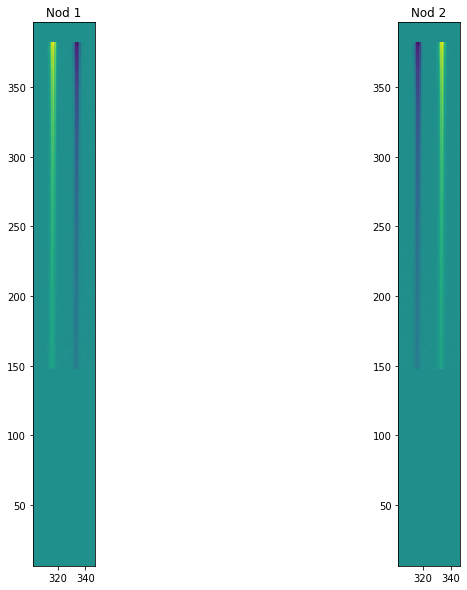

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,10])
ax[0].imshow(sp2[0].data, origin='lower', aspect='equal', interpolation='None')
ax[0].set_title('Nod 1')
ax[0].set_xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
ax[0].set_ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])

ax[1].imshow(sp2[1].data, origin='lower', aspect='equal', interpolation='None')
ax[1].set_title('Nod 2')
ax[1].set_xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
ax[1].set_ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])

## Checking the Photom() output

We retrieve the reference file from crds and use that to perform an arithmetic check that the calibration step is correctly implemented at 5 randomly chosen test locations in the bounding box. We also perform a check that the WCS information is consistent between the nods.

Point x    Point y   Wavelength
********************************
  317       290   8.700


  317       250   9.780
  310       225   10.383


  334       310    8.089
  340       200   10.939
Point x    Point y   Wavelength
********************************
  317       290   8.700
  317       250   9.780
  310       225   10.383
  334       310    8.089
  340       200   10.939


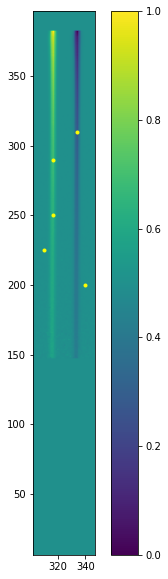

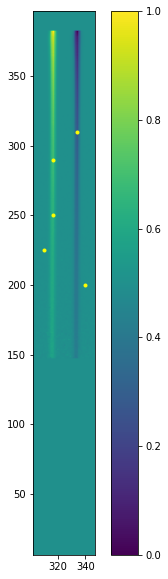

In [9]:
# Make waves
ffig = plt.figure(figsize=[6,10])
print('Point x    Point y   Wavelength')
print('********************************')

point1 = (317,290)
ra1, dec1, wave1 = sp2[0].meta.wcs(point1[0],point1[1])
print('  {0}       {1}   {2:.3f}'.format(point1[0], point1[1], wave1))


point2 = (317,250)
ra2, dec2, wave2 = sp2[0].meta.wcs(point2[0],point2[1])
print('  {0}       {1}   {2:.3f}'.format(point2[0], point2[1], wave2))
point3 = (310,225)
ra3, dec3, wave3 = sp2[0].meta.wcs(point3[0],point3[1])
print('  {0}       {1}   {2:.3f}'.format(point3[0], point3[1], wave3))
point4 = (334,310)
ra4, dec4, wave4 = sp2[0].meta.wcs(point4[0],point4[1])
print('  {0}       {1}    {2:.3f}'.format(point4[0], point4[1], wave4))
point5 = (340,200)
ra5, dec5, wave5 = sp2[0].meta.wcs(point5[0],point5[1])
print('  {0}       {1}   {2:.3f}'.format(point5[0], point5[1], wave5))
plt.imshow(sp2[0].data, origin='lower', aspect='equal')

xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]


plt.xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])


plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
plt.colorbar()
ffig.show()

waves = [wave1, wave2, wave3, wave4, wave5]

# Make waves2
ffig = plt.figure(figsize=[6,10])
print('Point x    Point y   Wavelength')
print('********************************')

point1 = (317,290)
ra1, dec1, wave1 = sp2[1].meta.wcs(point1[0],point1[1])
print('  {0}       {1}   {2:.3f}'.format(point1[0], point1[1], wave1))


point2 = (317,250)
ra2, dec2, wave2 = sp2[1].meta.wcs(point2[0],point2[1])
print('  {0}       {1}   {2:.3f}'.format(point2[0], point2[1], wave2))
point3 = (310,225)
ra3, dec3, wave3 = sp2[1].meta.wcs(point3[0],point3[1])
print('  {0}       {1}   {2:.3f}'.format(point3[0], point3[1], wave3))
point4 = (334,310)
ra4, dec4, wave4 = sp2[1].meta.wcs(point4[0],point4[1])
print('  {0}       {1}    {2:.3f}'.format(point4[0], point4[1], wave4))
point5 = (340,200)
ra5, dec5, wave5 = sp2[1].meta.wcs(point5[0],point5[1])
print('  {0}       {1}   {2:.3f}'.format(point5[0], point5[1], wave5))
plt.imshow(sp2[0].data, origin='lower', aspect='equal')

xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]


plt.xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])


plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
plt.colorbar()
ffig.show()

waves2 = [wave1, wave2, wave3, wave4, wave5]

Check that the WCS information matches for both nods.

In [10]:
assert(ww1 == ww2 for ww1, ww2 in zip(waves, waves2)), "wavelengths for points points don't match between nods"

Now we will check the photometric calibration arithmetic.

**Reminder** : The photom reference file contains a few single values, and then some columns. Amongst the initial single values is 'photmjsr', which is a conversion factor from DN/s to MJy/sr (reffile.phot_table['photmjsr']. Then there are wavelength and relresponse columns, which determine the wavelength-dependent part of the spectral response. At each given pixel, the DN/s slope value in the flat file output file is multiplied by a conversion factor conv_factor, where conv_factor = reffile.phot_table['photmjsr'] * reffile.phot_table['relresponse'] (wave)

In [11]:
reffile = [ss.meta.ref_file.photom.name for ss in sp2]
print(reffile)
assert reffile[0]==reffile[1], "Nods do not use the same Photom reference file"

# if this test passes and both nods use the same ref file, then just load in once and use for both.
basename = crds.core.config.pop_crds_uri(reffile[0])
filepath = crds.locate_file(basename, "jwst")
ref =  datamodels.open(filepath)

['crds://jwst_miri_photom_0072.fits', 'crds://jwst_miri_photom_0072.fits']


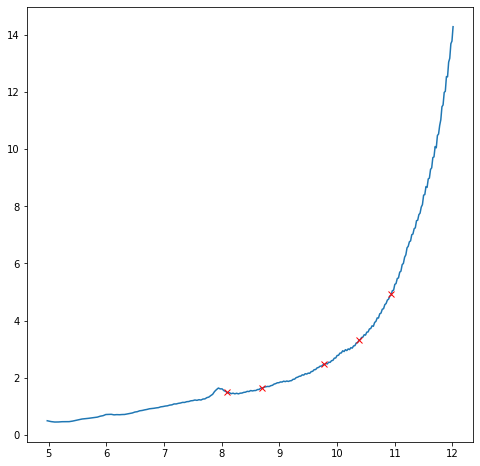

In [12]:
f = interpolate.interp1d(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
iresp = [f(ww) for ww in waves]

# plot for sanity check!
plt.figure(figsize=[8,8])
plt.plot(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
plt.plot(waves, iresp, 'rx', label='interpolated points')
plt.show()

Now create the list of conversion factors for each of these points.

In [13]:
fconv = [ref.phot_table['photmjsr'][0] * ir for ir in iresp]
print(fconv)

2021-04-22 22:23:42,896 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[99.16736187311677, 149.3253436135429, 200.79434236498622, 90.11472248476906, 297.6782481253979]


In the next cell we check that these conversion factors match the ratio of the flat fielded data and the photom-calibrated data at the location of our chosen points.

In [14]:
ff_files = glob.glob('*flat_field.fits')
print(ff_files)
flat = []

for f in ff_files:
    ffs = datamodels.open(f)
    flat.append(ffs)

print(ff)
    
# make sure we are combining the right nods for both files
if 'nod1' in sp2[0].meta.filename:
    if 'nod2' in ff_files[0]:
        flat.reverse()

if 'nod2' in sp2[0].meta.filename:
    if 'nod1' in ff_files[0]:
        flat.reverse()

print([ss.meta.filename for ss in sp2])
print([fff.meta.filename for fff in flat])

['miri_lrs_slit_pt_nod1_v2_flat_field.fits', 'miri_lrs_slit_pt_nod2_v2_flat_field.fits']


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpg20fihe2/miri_lrs_slit_pt_nod2_v2.3.fits
['miri_lrs_slit_pt_nod1_v2_cal.fits', 'miri_lrs_slit_pt_nod2_v2_cal.fits']
['miri_lrs_slit_pt_nod1_v2_flat_field.fits', 'miri_lrs_slit_pt_nod2_v2_flat_field.fits']


2021-04-22 22:23:43,060 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



((302.5, 346.5), (6.5, 396.5))


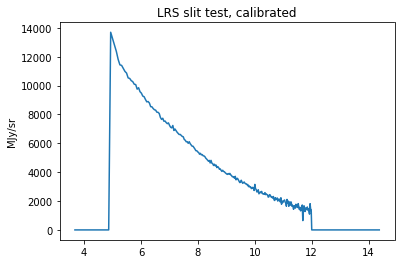

In [15]:
x,y = grid_from_bounding_box(flat[0].meta.wcs.bounding_box)
ra, dec, lam = flat[0].meta.wcs(x, y)

lam_vec = np.mean(lam, axis=1)

print(flat[0].meta.wcs.bounding_box)

flat_test = flat[0].data[6:396, :]
pho_test = sp2[0].data[6:396, :]

fig = plt.figure()
plt.plot(lam_vec, pho_test[:,318])
#plt.plot(lam_vec, flat_test[:,318])
plt.title('LRS slit test, calibrated')
plt.ylabel('MJy/sr')
plt.savefig('photom_slit_test_cal.png')
fig.show()

In [16]:
dratio = [sp2[0].data[yy,xx]/flat[0].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,ff))
    assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"

2021-04-22 22:23:43,185 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Ratio of data points     Calculated conversion factor
99.16737                99.16736
149.32535                149.32534
200.79434                200.79434
90.11472                90.11472
297.67825                297.67825


Now check the same for Nod 2

In [17]:
dratio2 = [sp2[1].data[yy,xx]/flat[1].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,ff))
    assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"

Ratio of data points     Calculated conversion factor
99.16737                99.16736
149.32535                149.32534
200.79434                200.79434
90.11472                90.11472
297.67825                297.67825


If these tests return no AssertionErrors, the test has passed.

Authors:
* K. Murray, kmurray@stsci.edu, MIRI Branch
* S. Kendrew, ssarah.kendrew@esa.int, ESA/MIRI Branch

Last updated:
Feb 1st 2021